In [14]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import math
from rasterio.windows import Window
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
from xml.dom import minidom

# Reading the image

In [15]:
def read_bands(file_name,crop_window):
    with rasterio.open(file_name) as img:
        bands=[]
        for i in range(1,5):
            bands.append(img.read(i,window=crop_window))
        return img,bands
    

# reading pixels arrays 

In [16]:
def read_pixel_array(b1_in,b2_in):
    
    width,height=b1_in.shape
    
    b11_in=b1_in * b1_in
    b22_in=b2_in*b2_in
    b12_in=b1_in*b2_in
    '''
     #flatten the arrarys 
    b1_in_flat=b1_in.flatten()
    b2_in_flat=b2_in.flatten()
    b11_in_flat=b11_in.flatten()
    b22_in_flat=b22_in.flatten()
    b12_in_flat=b12_in.flatten()
    '''
    b_in_list =list((b1_in,b2_in, b11_in,b22_in,b12_in)) 
    return b_in_list,width,height

# Sliding window aggregration

In [17]:
def sliding_window(band_in_list,width,height,w_size,method):
    
    delta=w_size//2
    col_extent_old = width - delta + 1
    row_extent = width - delta + 1
    col_extent = height - delta + 1
    
    #select the block indecies
    selector = lambda a: np.lib.stride_tricks.as_strided(a, shape=(row_extent,col_extent,delta,delta), strides=a.strides+a.strides)
    # Get offsetted indices across the height and width of input array
    #output_index_set = np.arange(row_extent)[:,None]*col_extent_old + np.arange(col_extent)
    #full_selector = np.lib.stride_tricks.as_strided(band_in_list[0], shape=(row_extent,col_extent,delta,delta), strides=band_in_list[0].strides+band_in_list[0].strides)
    
    #implement the selector on the arrays
    '''
    b1_in_selc=np.take(band_in_list[0],selector(band_in_list[0]).astype(float))
    b2_in_selc=np.take(band_in_list[1],selector(band_in_list[1]).astype(float))
    b11_in_selc=np.take(band_in_list[2],selector(band_in_list[2]).astype(float))
    b22_in_selc=np.take(band_in_list[3],selector(band_in_list[3]).astype(float))
    b12_in_selc=np.take(band_in_list[4],selector(band_in_list[4]).astype(float))
    '''
    band_out_list=[]
    if method=='sum':
        for band in band_in_list:
            band_out_list.append(np.sum(selector(band),axis=(2,3)))
    elif method=='mean':
        for band in band_in_list:
            band_out_list.append(np.mean(selector(band),axis=(2,3)))
    elif method=='max':
        for band in band_in_list:
            band_out_list.append(np.max(selector(band),axis=(2,3)))
    elif method=='min':
        for band in band_in_list:
            band_out_list.append(np.min(selector(band),axis=(2,3)))
    return band_out_list
    
    

# Normalization

using the Top of Atmosphere(TOA) reflectance coefficients from the xml meta data radiometric scale factor values 

In [18]:
def normalize_xml(bands,xml_file):
    xml_doc=minidom.parse(xml_file)
    nodes=xml_doc.getElementsByTagName("re:bandSpecificMetadata")
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("re:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("re:radiometricScaleFactor")[0].firstChild.data
            coeffs[i] = float(value)
    #norm_bands=[]
    for i in range(4):
        bands[i]=bands[i]*coeffs[i+1]
        
        #norm_bands.append(band)
    return bands


# NDVI

In [19]:
def ndvi(band_out_list):
    np.seterr(divide='ignore', invalid='ignore')
    return (band_out_list[1]-band_out_list[0])/(band_out_list[1]+band_out_list[0])

# Window Regression

In [20]:
def windowRegression(band_out_list,w):
    #x_diff = x_max-w+1
    #y_diff = y_max-w+1
    size = band_out_list[0].size
    count = w*w
    m = np.empty(size)
    
    if any(band.size!=size for band in band_out_list):
        print(size)
        #print(band.size)
        raise ValueError('In windowRegression: x_max and/or y_max inconsistent with length of a, b, aa, and / or ab')

    numerator = count * band_out_list[-1] - band_out_list[0]* band_out_list[1]
    denominator = count * band_out_list[2] - band_out_list[0] * band_out_list[0]
    m = numerator/denominator
    return m

    

# Window Correlation

In [21]:
def windowPearson(band_out_list,w):
    #x_diff = x_max-w+1
    #y_diff = y_max-w+1
    size = band_out_list[0].size
    count = w*w
    pearson = np.empty(count)
    if any(band.size!=size for band in band_out_list):
        raise ValueError('In windowPearson: x_max and/or y_max inconsistent with length of a, b, aa, ab, and / or bb')
    
    numerator = count * band_out_list[-1] - band_out_list[0]* band_out_list[1]
    denominator = np.sqrt(count * band_out_list[2] - band_out_list[0] * band_out_list[0]) * np.sqrt(count * band_out_list[3] - band_out_list[1] * band_out_list[1])
    pearson = numerator / denominator
    return pearson

# Writing images

In [34]:
def write_image(plt_array,plt_title,img):
    kwargs = img.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)

    # Write band calculations to a new raster file
    fout_name='Rasters/output_plt/'+plt_title+'.tif'
    with rasterio.open(fout_name, 'w', **kwargs) as dst:
        dst.write_band(1, plt_array.astype(rasterio.float32))
    class MidpointNormalize(colors.Normalize):
        """
        Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
        e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
        Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
        """
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


    # Set min/max values from NDVI range for image (excluding NAN)
    # set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
    min=np.nanmin(plt_array)
    max=np.nanmax(plt_array)
    mid=(min+max)/2

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    # diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
    cmap = plt.cm.RdYlGn 

    cax = ax.imshow(plt_array, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

    ax.axis('off')
    ax.set_title(plt_title, fontsize=18, fontweight='bold')

    cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)
    fig_out_name='Rasters/output_plt/'+plt_title+'.png'
    fig.savefig(fig_out_name, dpi=200, bbox_inches='tight', pad_inches=0.7)

    plt.show()

In [35]:
def create_tree_plot(file_name,window_size,crop_window,agg_func,xml_file):
 
    #crop_window=Window(0,0,250,250)
    img,bands=read_bands(file_name,crop_window)
    #print(len(bands),bands)
    norm_bands=normalize_xml(bands,xml_file)
    red_band=norm_bands[2]
    nir_band=norm_bands[3]
    band_in_list,width,height=read_pixel_array(red_band,nir_band)
    wout_size=2
    while wout_size<=window_size:
        band_out_list=sliding_window(band_in_list,width,height,wout_size,agg_func)
        ndvi_arr=ndvi(band_out_list)
        plt_title='NDVI with Window size '+str(wout_size) +' Aggregate function of '+agg_func
        #print(int(math.sqrt(ndvi_arr.shape[0])))
        write_image(ndvi_arr,plt_title,img)
        reg=windowRegression(band_out_list,wout_size)
        plt_title='Regression with Window size '+str(wout_size) +' Aggregate function of '+agg_func
        write_image(reg,plt_title,img)
        pearson=windowPearson(band_out_list,wout_size)
        plt_title='Correlation with Window size '+str(wout_size) +' Aggregate function of '+agg_func
        write_image(pearson,plt_title,img)
        wout_size*=2
        
        
    
    
        
        

In [36]:
def ndvi_analysis(file_name,window_size,agg_func,xml_file='Rasters/1460322_2014-08-13_RE2_3A_305154_metadata.xml',crop_window=Window(0,0,4000,4000)):
     #crop_window=Window(0,0,250,250)
    img,bands=read_bands(file_name,crop_window)
    #print(len(bands),bands)
    norm_bands=normalize_xml(bands,xml_file)
    red_band=norm_bands[2]
    nir_band=norm_bands[3]
    band_in_list,width,height=read_pixel_array(red_band,nir_band)
    band_out_list=sliding_window(band_in_list,width,height,window_size,agg_func)
    ndvi_arr=ndvi(band_out_list)
    return ndvi_arr
    

In [37]:
def regression_analysis(file_name,window_size,agg_func,xml_file='Rasters/1460322_2014-08-13_RE2_3A_305154_metadata.xml',crop_window=Window(0,0,4000,4000)):
     #crop_window=Window(0,0,250,250)
    img,bands=read_bands(file_name,crop_window)
    #print(len(bands),bands)
    norm_bands=normalize_xml(bands,xml_file)
    red_band=norm_bands[2]
    nir_band=norm_bands[3]
    band_in_list,width,height=read_pixel_array(red_band,nir_band)
    band_out_list=sliding_window(band_in_list,width,height,window_size,agg_func)
    reg_arr=windowRegression(band_out_list,window_size)
    return reg_arr
    

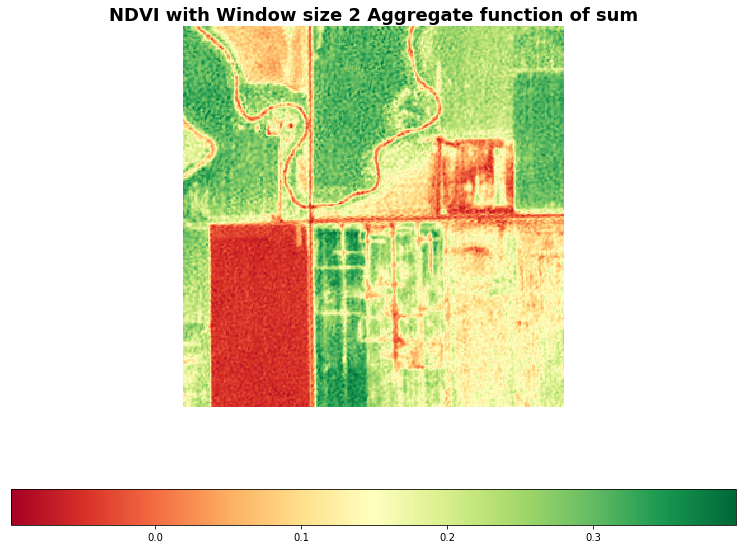

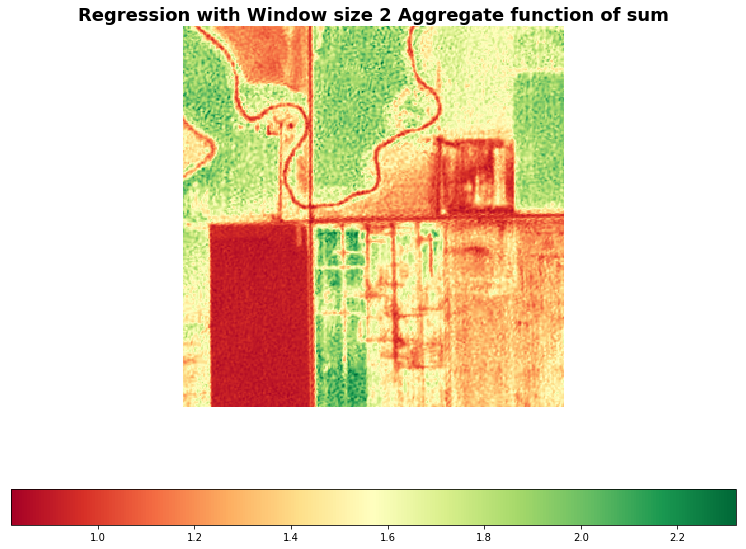

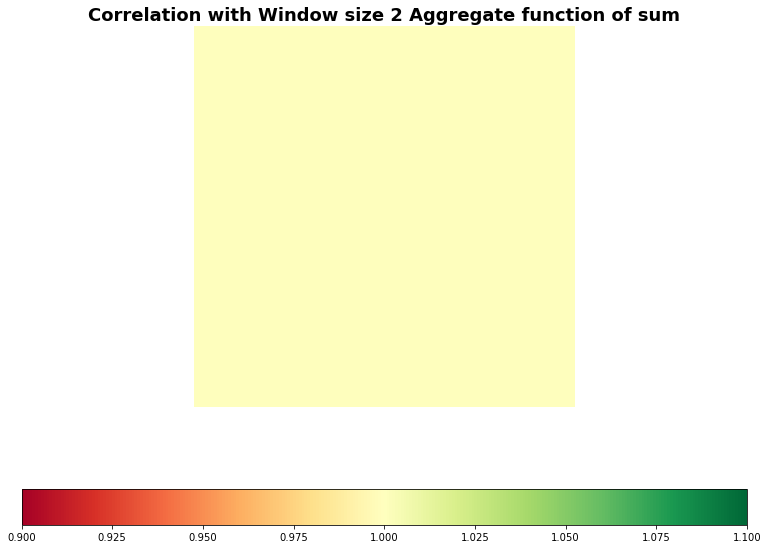

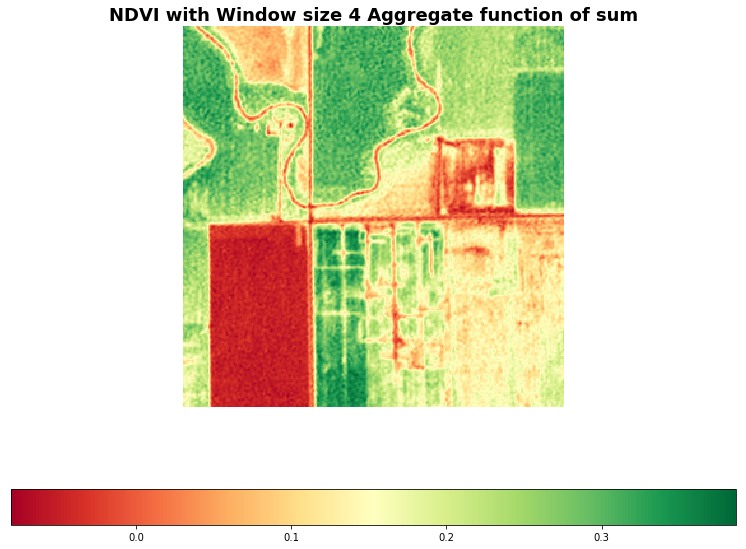

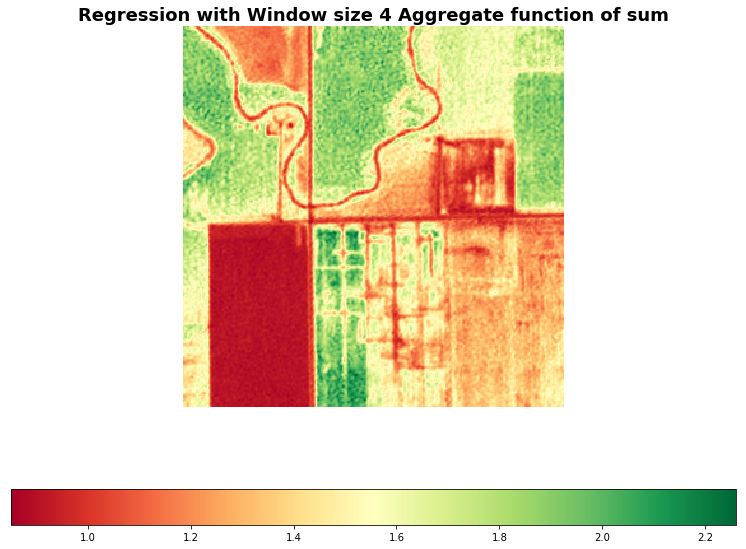

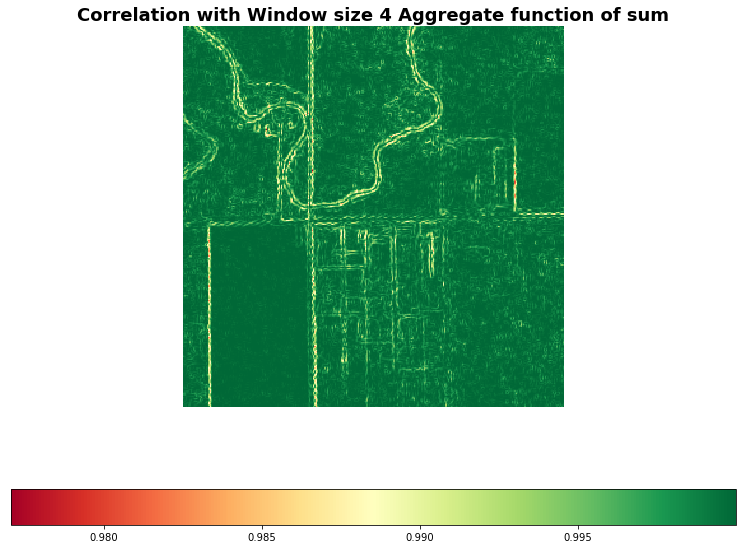

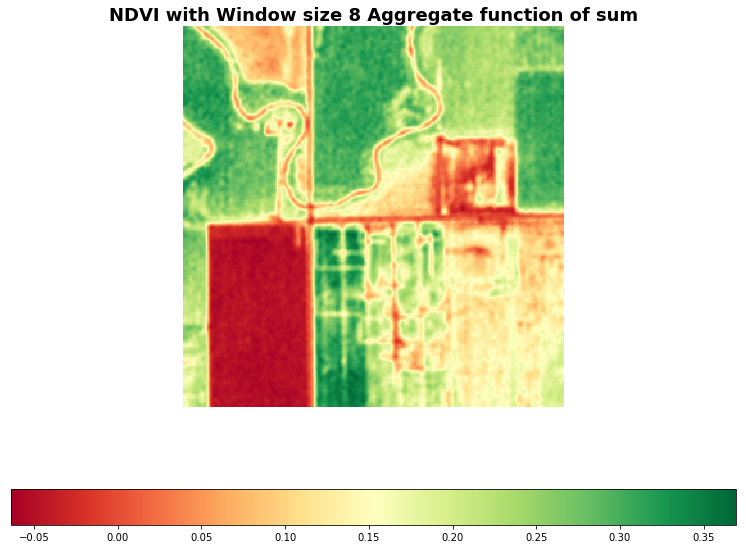

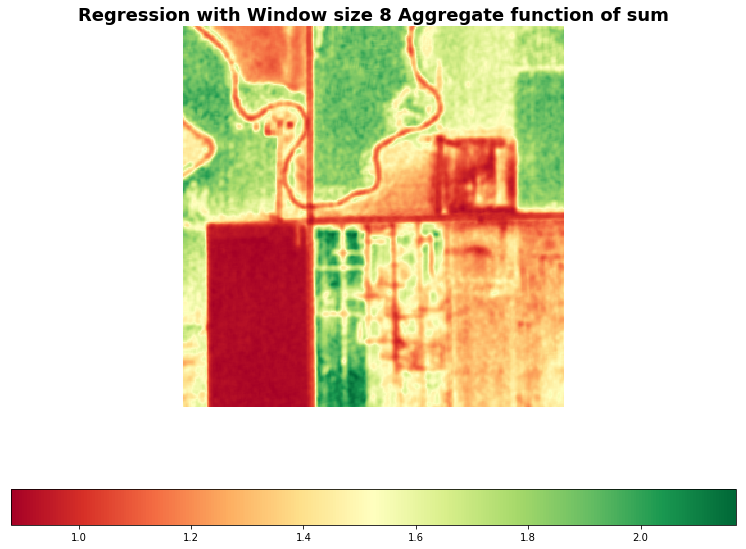

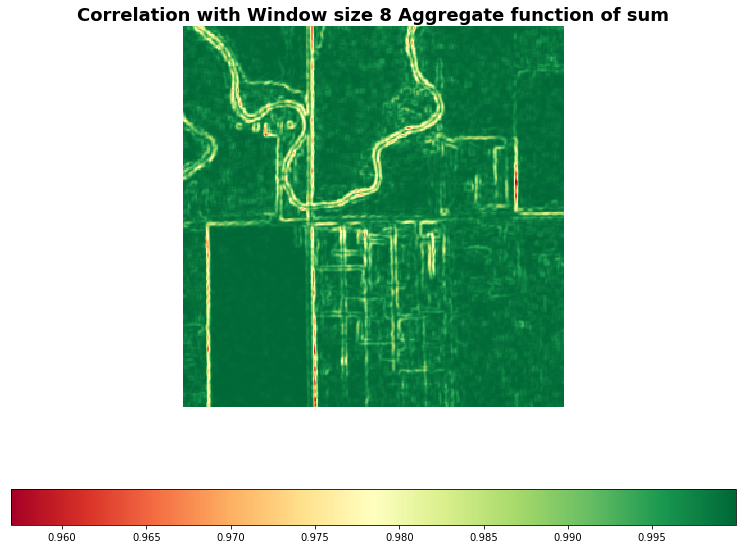

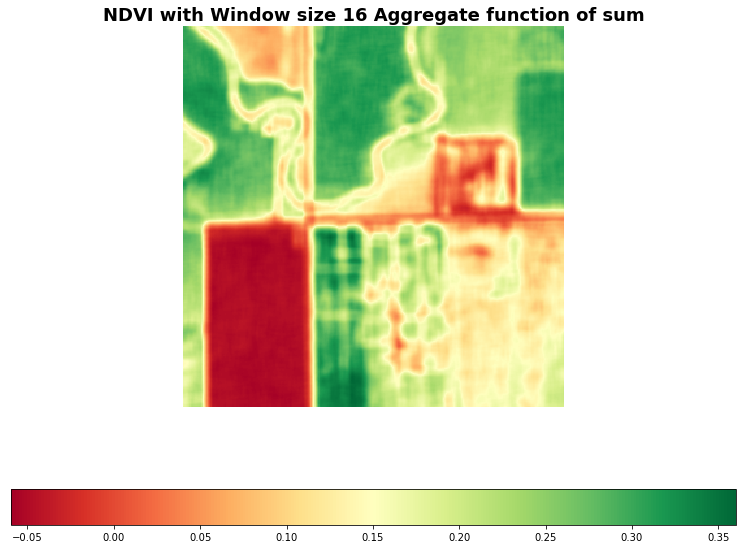

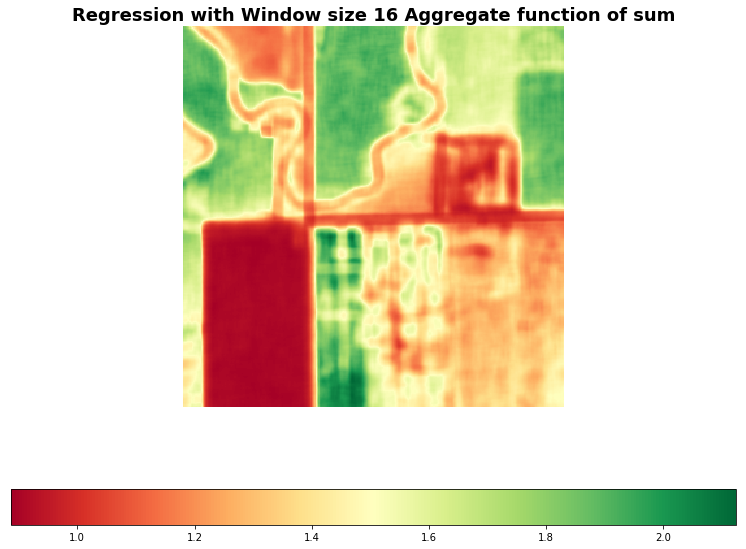

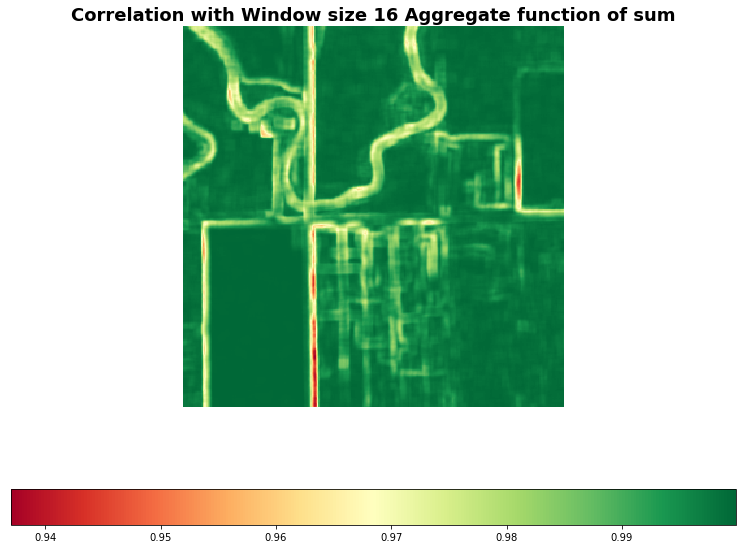

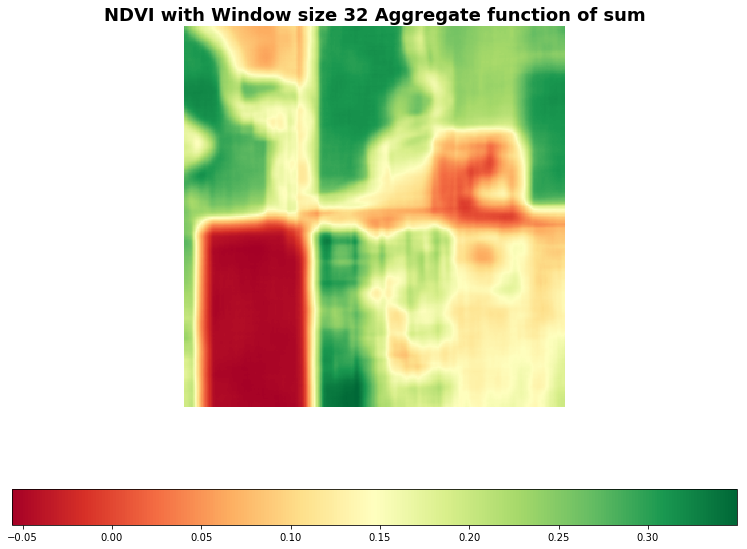

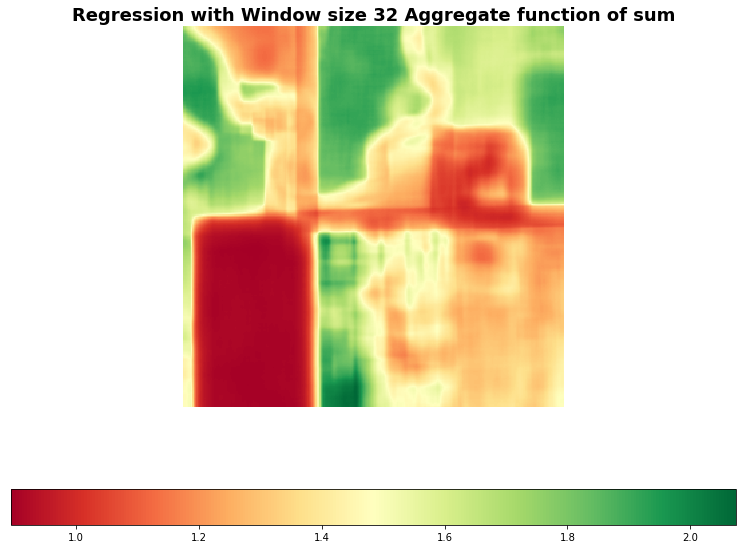

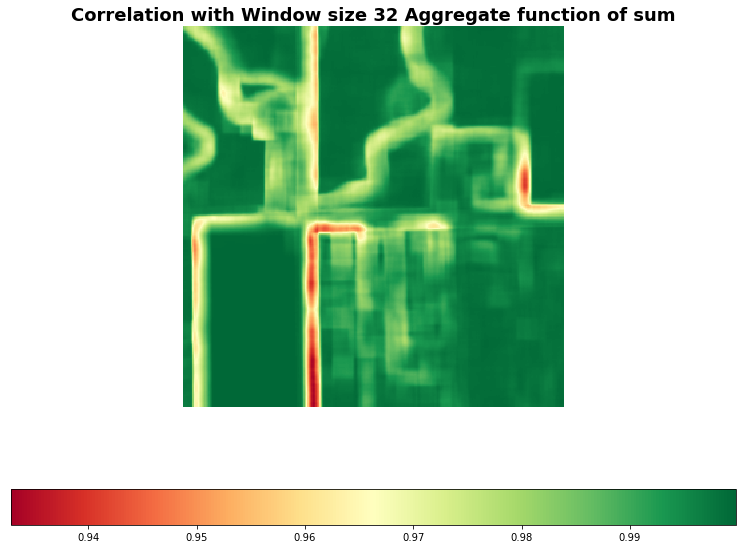

In [39]:
#%%timeit
#create_tree_plot(file_name='Rasters/1460322_2014-08-13_RE2_3A_305154.tif',window_size=32,crop_window=Window(0,0,300,300),agg_func='sum',xml_file='Rasters/1460322_2014-08-13_RE2_3A_305154_metadata.xml')